<h1> Работа с датасетом MNIST <span class="tocSkip"></span></h1>

<h1> Задача: <span class="tocSkip"></span></h1>

Используя образцы рукописного написания цифр из датасета MNIST:
- осуществить бинарную и мультиклассовую классификации;
- написать с нуля и обучить простейшие полносвязные нейронные сети;
- получить оценки качества моделей с помощью classification_report;
- сделать выводы.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor

from tqdm import tqdm

from IPython.display import clear_output

from sklearn.metrics import classification_report, accuracy_score, f1_score

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

!nvidia-smi

CUDA is available!  Training on GPU ...
cuda
Thu Jan 12 09:32:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                           

### Подготовка данных
 - Получение Датасета
 - Получение Даталоадера
 - Просмотр данных

In [3]:
train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform=ToTensor()
)
test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
BATCH_SIZE = 64

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [6]:
### Целевое значение
next(iter(train_dataloader))[1]

tensor([7, 1, 3, 0, 0, 3, 1, 8, 7, 7, 5, 7, 9, 7, 7, 3, 2, 0, 8, 5, 7, 9, 0, 9,
        6, 7, 8, 7, 9, 2, 0, 8, 6, 3, 4, 2, 4, 8, 4, 8, 9, 5, 1, 0, 3, 1, 7, 1,
        0, 9, 8, 6, 1, 0, 5, 9, 9, 4, 3, 5, 1, 6, 8, 9])

In [7]:
### Torch tensor
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

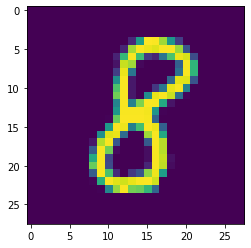

In [8]:
for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

### Бинарная классификация

Построим нейронную сеть, чтобы для решения задачи бинарной классификации (является ли цифра 9-кой или нет)

In [9]:
class IsOne(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = torch.nn.Linear(28*28, 256)
        self.Linear2 = torch.nn.Linear(256, 64)
        self.Linear3 = torch.nn.Linear(64, 1)
        self.relu = torch.nn.ReLU()
        self.Sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x).squeeze(1)
        x = self.Sigmoid(x)
        return x

In [10]:
model = IsOne().to(device)

#### Функция, вычисляющая лосс

In [11]:
def loss_function(true, pred):
    loss = torch.nn.BCELoss()
    return loss(pred, true)

#### Оптимизатор

In [12]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)

#### Построим процесс обучения нейронной сети

In [13]:
NUM_EPOCHS = 10
WANTED_LABEL = 9

In [14]:
train_loss = []
test_loss = []
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train(True)
    train_loss_epoch = 0
    test_loss_epoch = 0
    for X, y in train_dataloader:
        model.zero_grad()
        true = (y == WANTED_LABEL).float().to(device)
        predictions = model.forward(X.to(device))
        loss_value = loss_function(true, predictions)
        loss_value.backward()
        train_loss_epoch += loss_value.item()/len(train_dataloader)
        optimizer.step()
        
    train_loss.append(train_loss_epoch)
    #print(train_loss)
    model.train(False)
    for X, y in test_dataloader:
        true = (y == WANTED_LABEL).float().to(device)
        predictions = model.forward(X.to(device))
        loss_value = loss_function(true, predictions)
        test_loss_epoch += loss_value.item()/len(test_dataloader)
    test_loss.append(test_loss_epoch)
    # print(epoch, train_loss[-1], test_loss[-1])


100%|██████████| 10/10 [01:17<00:00,  7.70s/it]


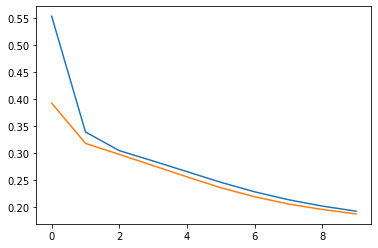

In [15]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

In [16]:
preds = []
reals = []

with torch.no_grad():
  for X, y in test_dataloader:
      preds.append(model(X.to(device)).detach().cpu().numpy())
      reals.append((y==WANTED_LABEL).int().to(device).cpu().numpy())

In [17]:
preds = (np.concatenate(preds)>=0.5).astype(int)
reals = np.concatenate(reals)

In [18]:
accuracy_score(preds, reals), f1_score(reals, preds)

(0.9008413461538461, 0.03131115459882583)

In [19]:
print(classification_report(reals, preds))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      8978
           1       1.00      0.02      0.03      1006

    accuracy                           0.90      9984
   macro avg       0.95      0.51      0.49      9984
weighted avg       0.91      0.90      0.86      9984



### Мультиклассовая классфикация

Построим нейронную сеть, чтобы для решения задачи мультиклассовой классфикации.

Теперь будем классифицировать все данные на 10 классов, а не определять какую-то одну цифру.

In [20]:
batch_size = 64
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [21]:
num_features = 10

In [22]:
class Multy(torch.nn.Module):
    def __init__(self):
        super().__init__()

                 
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(28*28, 512), 
            torch.nn.Dropout(p=0.3),
            torch.nn.ReLU(),                       
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, num_features),
            torch.nn.ReLU(),
            torch.nn.Softmax(dim = 1)
        )

    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.seq(x)
        return x

#### Параметры

In [23]:
NUM_EPOCHS = 40
lr = 1e-4
criterion = torch.nn.CrossEntropyLoss()
model = Multy().to(device)
optimizer = torch.optim.Adam(model.parameters())

#### Процесс обучения нейронной сети

In [24]:
model

Multy(
  (seq): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
    (10): ReLU()
    (11): Softmax(dim=1)
  )
)

In [25]:
def train(model, optimizer, epochs=NUM_EPOCHS, learning_rate=lr):  
  train_loss = []
  val_loss = []
  pred = []
  val_acc = []

  for epoch in tqdm(range(epochs)):
      model.train()
      train_loss_epoch = 0
      val_loss_epoch = 0
      for X, y in train_dataloader:
          model.zero_grad()
          features = X.to(device)
          target = y.to(device)
          predictions = model(features)
          loss = criterion(predictions, target)
          loss.backward()
          train_loss_epoch += loss.item()/len(train_dataloader)
          optimizer.step()
      train_loss.append(train_loss_epoch)

      preds = []
      targets = []
      model.eval()
      for X, y in test_dataloader:
          features = X.to(device)
          target = y.to(device)
          predictions = model(features)
          loss = criterion(predictions, target)
          val_loss_epoch += loss.item()/len(test_dataloader)
          preds.append(predictions.argmax(axis = 1).detach().cpu().numpy())
          targets.append(target.cpu().numpy())

      val_loss.append(val_loss_epoch)
      val_acc.append(f1_score(np.concatenate(targets), np.concatenate(preds), average = 'micro'))

      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
      clear_output(True)
      if train_loss is not None:
          ax.plot(train_loss, label='general train history')
          ax.set_xlabel('Epoch')
          ax.set_title('Train and Val loss')
      if val_loss is not None:
          ax.plot(val_loss, label='general valid history')
      plt.legend()
      plt.show()  

      print(f'\nEpoch: {epoch+1:01}')
      print(f'Train Loss: {train_loss[epoch]:.3f}')
      print(f' Val. Loss: {val_loss[epoch]:.3f} | Val.F_1: {val_acc[epoch]:.3f}')

  return train_loss, val_loss, val_acc

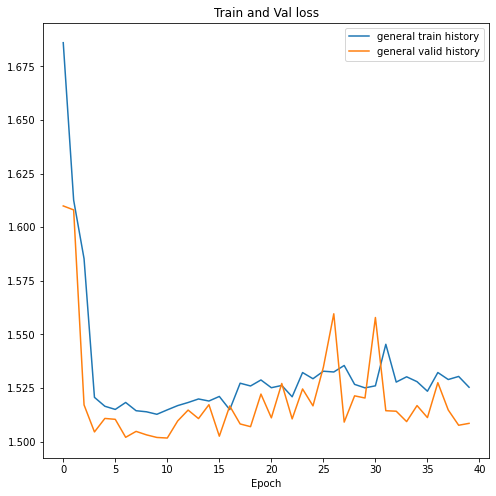

100%|██████████| 40/40 [05:42<00:00,  8.55s/it]


Epoch: 40
Train Loss: 1.525
 Val. Loss: 1.509 | Val.F_1: 0.953


In [26]:
train_history, val_history, val_acc = train(model, optimizer=optimizer)

Сохраним веса получившейся модели. 

In [27]:
torch.save(model.state_dict(), 'HW-model.pt')

In [28]:
preds = []
reals = []
for X, y in test_dataloader:
    preds.append(model(X.to(device)).detach().cpu().numpy())
    reals.append(y.to(device).int().cpu().numpy())

In [29]:
preds[0].argmax(axis = 1)

array([4, 4, 4, 8, 8, 6, 1, 6, 1, 7, 7, 8, 5, 9, 7, 7, 1, 4, 5, 5, 7, 9,
       9, 9, 7, 2, 3, 5, 7, 7, 1, 4, 7, 6, 8, 0, 9, 8, 1, 1, 2, 5, 1, 4,
       0, 4, 6, 5, 0, 9, 9, 2, 0, 1, 5, 6, 9, 0, 2, 1, 7, 0, 7, 4])

In [30]:
preds = (np.concatenate(preds).argmax(axis = 1)).astype(int)
len(preds)

9984

In [31]:
reals = np.concatenate(reals)
len(reals)

9984

In [32]:
print(classification_report(reals,preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       978
           1       0.98      0.99      0.99      1132
           2       0.95      0.95      0.95      1031
           3       0.98      0.89      0.93      1009
           4       0.92      0.98      0.95       981
           5       0.93      0.97      0.95       890
           6       0.98      0.95      0.96       957
           7       0.96      0.96      0.96      1028
           8       0.89      0.97      0.93       971
           9       0.98      0.89      0.93      1007

    accuracy                           0.95      9984
   macro avg       0.95      0.95      0.95      9984
weighted avg       0.95      0.95      0.95      9984



### Вывод:
1. Модель обучалась 40 эпох и достигла неплохих показателей, на мой взгляд. F-1 = 0.94. 
2. Использовились лосс-функция CrossEntropyLoss() и оптимизатор Adam с дефолтными параметрами. 
3. На 24 эпохе loss значительно упал, и по графику видно, что 27 эпох в целом было бы достаточно. 
4. Dropout = 0.3 дает значительное уменьшение lossa (и соответственно, прирост в метрике) по сравнению с Dropout = 0.1. Проверено эмпирическим путем.
